In [1]:
import pandas as pd
import numpy as np
import pystan
import pandas as pd
import numpy as np
import time
import diagnostics
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import warnings; warnings.simplefilter('ignore')

In [2]:
path = 'daily_brand_counts.csv'

In [3]:
data = pd.read_csv(path, index_col=0)

In [4]:
nike = data[data['brand'] == 'Nike']
nike.columns =['brand', 'date', 'volume']
nike.date = pd.to_datetime(nike.date)

In [5]:
def EngineerFeatures(daily_volume, days_rolling, days_forward):
    over_threshold = daily_volume[daily_volume['volume'] > 50]
    
    # Extract date information from transaction data

    over_threshold['day_of_week'] = over_threshold['date'].dt.day_name()
    over_threshold['month'] = over_threshold['date'].dt.month_name()
    over_threshold['year'] = over_threshold['date'].dt.year
    over_threshold['year'] = over_threshold['year'].astype('category')
    
    # Calculate moving average metrics
    
    over_threshold['rolling_mean_week'] = over_threshold['volume'].rolling(days_rolling).mean()
    over_threshold['rolling_median_week'] = over_threshold['volume'].rolling(days_rolling).median()
    over_threshold['rolling_max_week'] = over_threshold['volume'].rolling(days_rolling).max()
    over_threshold['projected_volume'] = over_threshold.volume.shift(-days_forward)
    
    # Create predictor for holidays

    dr = pd.date_range(start='2017-02-16', end='2019-06-16')
    df = pd.DataFrame()
    df['Date'] = dr

    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())
    holidays = list(holidays.strftime("%Y-%m-%d"))
    non_federal_holidays = ['2017-10-31', '2018-10-31', '2017-11-24', '2017-11-25', '2017-11-26', '2018-11-23', 
                            '2018-11-24', '2018-11-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
                            '2017-12-30', '2018-12-26', '2018-12-27', '2017-12-28', '2018-12-29', '2017-12-30']
    
    holidates = holidays + non_federal_holidays 

    over_threshold['holiday'] = over_threshold['date'].isin(non_federal_holidays).astype(int)
    
    # Load sneaker releases data

    sneaker_releases = pd.read_csv('sneaker_metadata.csv')
    
#     sneaker_releases['is_yeezy'] = sneaker_releases.model.str.contains('Yeezy').astype(int)
   
#     special_releases = sneaker_releases.loc[:, ('is_yeezy', 'date')]
    
#     special_releases = special_releases.groupby('date').sum()
#     special_releases['date'] = special_releases.index
#     special_releases = special_releases.reset_index(drop=True)
#     special_releases.date = pd.to_datetime(special_releases.date)
    
#     over_threshold = pd.merge(over_threshold, special_releases, how = 'left', on = 'date')
#     over_threshold.is_yeezy = over_threshold.is_yeezy.fillna(0)
#     over_threshold['is_yeezy'] = over_threshold['is_yeezy'].shift(-days_forward)
    

    non_nike_releases = sneaker_releases[sneaker_releases['brand'] == 'adidas']
    non_nike_releases.releaseDate = non_nike_releases.releaseDate.str.split(' ').str[0]
    non_nike_releases = non_nike_releases.loc[:, ('brand', 'releaseDate')]
    
    non_release_count = non_nike_releases.groupby('releaseDate').count()
    non_release_count['date'] = non_release_count.index
    non_release_count.date = pd.to_datetime(non_release_count.date)
    non_release_count = non_release_count.reset_index(drop=True)
    non_release_count.columns = ['non_nike_releases', 'date']

    
    merged_release = pd.merge(over_threshold, non_release_count, how = 'left', on='date')
    merged_release.non_nike_releases = merged_release.non_nike_releases.fillna(0)
    
    merged_release['non_nike_releases'] = merged_release['non_nike_releases'].shift(-days_forward)
    
    return merged_release
#     return over_threshold

In [6]:
model_df = EngineerFeatures(nike, 7, 5)

In [7]:
model_df.head()

,brand,date,volume,day_of_week,month,year,rolling_mean_week,rolling_median_week,rolling_max_week,projected_volume,holiday,non_nike_releases
0,Nike,2017-08-22,58,Tuesday,August,2017,NaN,NaN,NaN,70.0,0,0.0
1,Nike,2017-08-23,96,Wednesday,August,2017,NaN,NaN,NaN,51.0,0,0.0
2,Nike,2017-08-24,309,Thursday,August,2017,NaN,NaN,NaN,59.0,0,2.0
3,Nike,2017-08-25,89,Friday,August,2017,NaN,NaN,NaN,64.0,0,3.0
4,Nike,2017-08-26,87,Saturday,August,2017,NaN,NaN,NaN,109.0,0,0.0


In [8]:
cat_bool = ['day_of_week', 'month', 'year', 'holiday', 'date']
cat_df = model_df.loc[:, (cat_bool)]

In [9]:
numer_df = model_df.loc[:, ('volume', 'rolling_mean_week', 'rolling_median_week', 
                    'rolling_max_week', 'non_nike_releases', 'projected_volume')]

In [10]:
scaler = StandardScaler() 
scaled_values = scaler.fit_transform(numer_df) 
numer_df.loc[:,:] = scaled_values

In [11]:
model_df = pd.concat([cat_df, numer_df], axis=1, sort=False)
model_df.date = pd.to_datetime(model_df.date)

In [12]:
def SplitTrainTest(model_df, train_pct):
    
    model_df = model_df[model_df['date'] > '2017-10-30']
    data = model_df.drop("date", axis=1)
    
    rf_df = pd.get_dummies(data)
    rf_df = rf_df.dropna()
    rf_df = rf_df.reset_index(drop = True)

    # Labels are the values we want to predict
    labels = np.array(rf_df['projected_volume'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features= rf_df.drop('projected_volume', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)
    
    split_axis = round(len(model_df) * train_pct)
    
    train = rf_df[:split_axis]
    test = rf_df[split_axis:-6]

    train_labels = np.array(train['projected_volume'])
    train_features = train.drop('projected_volume', axis = 1)

    test_labels = np.array(test['projected_volume'])
    test_features = test.drop('projected_volume', axis = 1)

    return train_features, train_labels, test_features, test_labels

In [13]:
train_features, train_labels, test_features, test_labels = SplitTrainTest(model_df, train_pct = 0.9)

In [14]:
lin_reg_normal = """
    /* Spec for robust linear regression model */
    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of features
        matrix[N, K] X;                     // feature matrix
        real y[N];          // target
    }
    parameters {
        real alpha;                         // constant
        vector[K] beta;                     // feature coefficients
        real<lower=0> sigma;
    }
    model { 
        alpha ~ normal(0,2);              // prior
        beta ~ normal(0,2);              // prior
        y ~ normal(alpha + X * beta, sigma);         // likelihood
    }
    generated quantities {}
    """

In [15]:
start = time.time()

stan_datadict = {}
stan_datadict['N'] = train_features.shape[0]
stan_datadict['K'] = train_features.shape[1]
stan_datadict['X'] = train_features.values
stan_datadict['y'] = train_labels

model = pystan.StanModel(model_code=lin_reg_normal)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d5dc90c9cb521470cde6ef08c270095 NOW.


In [16]:
fit = model.sampling(data=stan_datadict,
                warmup=250,
                iter = 1000, 
                verbose = True)

end = time.time()
print(str(end-start))

73.871915102005


In [17]:
print(diagnostics.check_treedepth(fit))
print(diagnostics.check_energy(fit))
print(diagnostics.check_div(fit))

38 of 3000 iterations saturated the maximum tree depth of 10 (1.2666666666666666%)
  Run again with max_depth set to a larger value to avoid saturation
None
E-BFMI indicated no pathological behavior
None
0.0 of 3000 iterations ended with a divergence (0.0%)
None


In [18]:
b = fit.extract(['alpha'])['alpha'].mean()
w = fit.extract(['beta'])['beta'].mean(axis=0)

In [19]:
b

0.005699407414867738

In [20]:
w

array([-0.09483534,  0.23942135, -0.03205957,  0.14274761, -0.01423736,
        0.04493981, -0.01941183, -0.00169911,  0.08218581,  0.18394247,
       -0.06586453, -0.26798205, -0.08122704, -0.17122466,  0.24084508,
        0.69201338, -0.21116861, -0.58694305,  0.02190023, -0.29704462,
       -0.37867465, -0.26043726,  0.69082443,  0.15021652,  0.11535383,
       -1.06086815, -0.12956443,  1.09380703])

In [21]:
train_features.columns

Index(['holiday', 'volume', 'rolling_mean_week', 'rolling_median_week',
       'rolling_max_week', 'non_nike_releases', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'year_2017',
       'year_2018', 'year_2019'],
      dtype='object')

In [22]:
predictions = test_features@w + b

In [23]:
numer_test_features = test_features.loc[:, ('volume', 'rolling_mean_week', 'rolling_median_week', 
                    'rolling_max_week', 'non_nike_releases')]

In [24]:
unscale_test = pd.concat([numer_test_features, predictions],axis=1)
unscale_test.columns = ['volume', 'rolling_mean_week', 'rolling_median_week', 
                    'rolling_max_week', 'non_nike_releases', 'projected_volume']
unscaled_predictions = scaler.inverse_transform(unscale_test)
unscale_test.loc[:,:] = unscaled_predictions
unscaled_predictions = unscale_test.projected_volume

In [25]:
test_labels_df = pd.Series(test_labels)
test_labels_df.index = numer_test_features.index
unscale_labels = pd.concat([numer_test_features, test_labels_df],axis=1)
unscale_labels.columns = ['volume', 'rolling_mean_week', 'rolling_median_week', 
                    'rolling_max_week', 'non_nike_releases', 'projected_volume']

In [26]:
unscaled_test_labels = scaler.inverse_transform(unscale_labels)
unscale_labels.loc[:,:] = unscaled_test_labels

In [27]:
observed = unscale_labels.projected_volume
persistance_prediction = unscale_labels.volume

[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

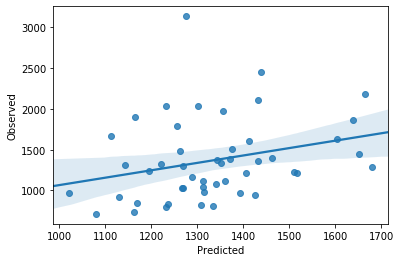

In [28]:
fig = sns.regplot(x=unscaled_predictions, y=observed)
fig.set(xlabel='Predicted', ylabel='Observed')

In [29]:
print('Mean Absolute Percentage Error - Baseline:', round(np.mean(np.abs((observed - persistance_prediction) / observed)) * 100))
print('Mean Absolute Percentage Error - Bayes:', round(np.mean(np.abs((observed - unscaled_predictions) / observed)) * 100))


Mean Absolute Percentage Error - Baseline: 35.0
Mean Absolute Percentage Error - Bayes: 26.0


In [30]:
samples = fit.extract()
beta = samples['beta']

col_names = test_features.columns
weights = pd.DataFrame(beta)
weights.columns = col_names
melted_weights = weights.melt()

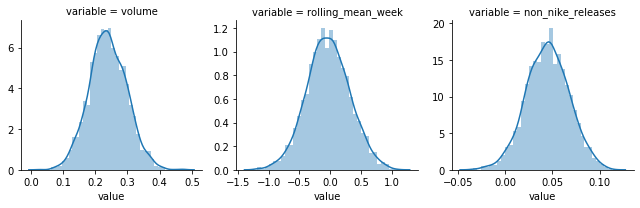

In [32]:
desired_features = ['volume', 'rolling_mean_week', 'upcoming_release', 'non_nike_releases']
posterior_features = melted_weights[melted_weights['variable'].isin(desired_features)]
g = sns.FacetGrid(posterior_features, col='variable', sharex=False, sharey=False)
g = g.map(sns.distplot, "value")